In [2]:
from tslearn.utils import to_time_series_dataset
import json
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu

label_df = pd.read_csv('/home/woody/iwso/iwso092h/empkins/notebooks/labels.csv')
parent_dir = '/home/vault/empkins/tpD/D02/Students/Aditya/facau_data'
ids = os.listdir(parent_dir)
ids = os.listdir(parent_dir)

numeric_ids = [id for id in ids if id.isdigit()]

/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


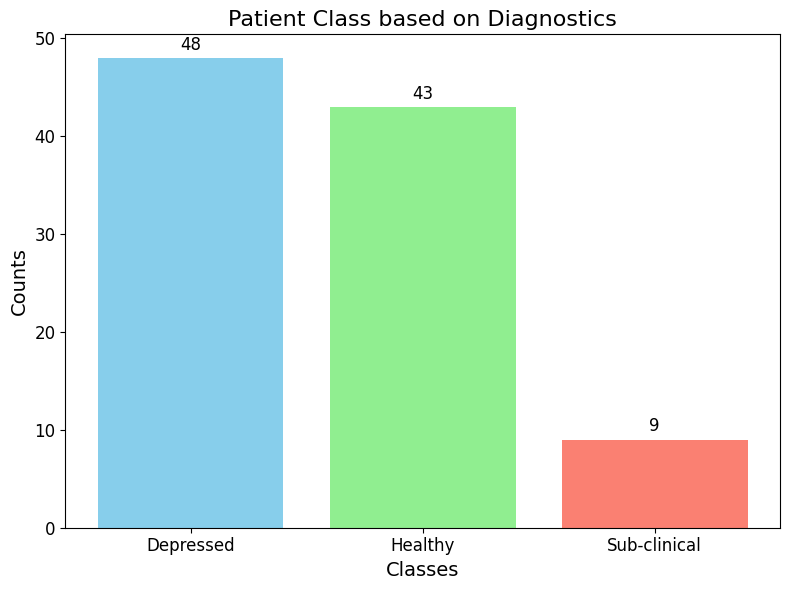

In [3]:
import matplotlib.pyplot as plt

# Data
labels = ['Depressed', 'Healthy', 'Sub-clinical']
counts = [48, 43, 9]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts, color=['skyblue', 'lightgreen', 'salmon'])

# Add title and axis labels
plt.title('Patient Class based on Diagnostics', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate bars with counts
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords='offset points',
                 ha='center', va='bottom', fontsize=12)

# Show plot
plt.tight_layout()

plt.savefig('/home/woody/iwso/iwso092h/empkins/plots/patient_classes_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

In [4]:
valid_ids = []

coping_list = []

ids = os.listdir(parent_dir)
for id in ids:
    tagret_path = os.path.join(parent_dir, str(id), 'ei.json')
    if os.path.isfile(tagret_path):  # Check if the file exists
        try:
            with open(tagret_path, 'r') as f:
                coping_data = json.load(f)
            df = pd.DataFrame.from_dict(coping_data)
            if not df.empty:
                coping_list.append(df)
                valid_ids.append(int(id))  # Add valid ID to the list
        except (FileNotFoundError, ValueError, json.JSONDecodeError):
            pass

id_df = pd.DataFrame({'Participant ID': valid_ids})

label_df['Participant ID'] = label_df['Participant ID'].astype(int)

# Merge combined_df with id_df to rearrange according to the directory IDs
reordered_df = id_df.merge(label_df, on='Participant ID', how='left')
reordered_df.shape
len(coping_list)
coping_list = [df for df in coping_list if len(df) > 0]

columns_to_include = [
    # 'fac_AU01int',  # Inner Brow Raiser
    # 'fac_AU04int',  # Brow Lowerer
    'fac_AU06int',  # Cheek Raiser
    # 'fac_AU05int', 
    # 'fac_AU07int',
    'fac_AU12int',  # Lip Corner Puller
    # 'fac_AU15int',  # Lip Corner Depressor
    # 'fac_AU17int',   # Chin Raiser
    # 'fac_AU23int'
]

filtered_dataframes = [df[columns_to_include] for df in coping_list]

# for i, df in enumerate(filtered_dataframes):
#     print(f"DataFrame {i} shape: {df.shape}")
#     print(f"DataFrame {i} columns: {df.columns.tolist()}")

coping_list = filtered_dataframes

y = reordered_df['Label']
y = pd.Series(y)
if y.isna().sum() > 0:
    print(f"Found {y.isna().sum()} NaN values in the labels. Handling them...")
    y.fillna(y.mode()[0], inplace=True)
y = y.apply(lambda x: 0 if x == 0.5 else x).astype(int)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
dataframes = coping_list

max_length_limit = 3000  

max_length = min(max(df.shape[0] for df in dataframes), max_length_limit)

def pad_or_trim_dataframe(df, max_length):
    if df.shape[0] > max_length:
        return df.iloc[:max_length].to_numpy()
    else:
        padding_length = max_length - df.shape[0]
        padding = np.zeros((padding_length, df.shape[1]))
        return np.vstack([df.to_numpy(), padding])

processed_arrays = [pad_or_trim_dataframe(df, max_length) for df in dataframes]

data_array = np.stack(processed_arrays, axis=1)

print(f"Combined data array shape: {data_array.shape}")


scaler = StandardScaler()

n_time_series, n_samples, n_features = data_array.shape
data_array_reshaped = data_array.reshape(-1, n_features)

data_array_normalized = scaler.fit_transform(data_array_reshaped)

data_array_normalized = data_array_normalized.reshape(n_time_series, n_samples, n_features)

reshaped_array = np.transpose(data_array_normalized, (1, 2, 0))

summed_array = np.sum(reshaped_array, axis=1)

result_array = np.expand_dims(summed_array, axis=1)

Found 3 NaN values in the labels. Handling them...
Combined data array shape: (3000, 100, 2)


In [5]:
result_array.shape

(100, 1, 3000)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Flatten the timestamps dimension
reshaped_array_flat = result_array.reshape(100, 3000)

# Split data based on depression label
depressed = reshaped_array_flat[y == 1]
non_depressed = reshaped_array_flat[y == 0]

# Descriptive statistics
mean_depressed = np.mean(depressed, axis=0)
mean_non_depressed = np.mean(non_depressed, axis=0)
std_depressed = np.std(depressed, axis=0)
std_non_depressed = np.std(non_depressed, axis=0)

# T-Test
t_stat, p_value = ttest_ind(depressed, non_depressed, axis=0)

In [7]:
t_stat, p_value = ttest_ind(mean_depressed, mean_non_depressed, axis=0)
print(p_value.mean())

0.0


In [8]:
from scipy.stats import ttest_ind, mannwhitneyu

# Welch's t-test
t_statistic, p_value_welch = ttest_ind(mean_depressed, mean_non_depressed, equal_var=False)

# Mann-Whitney U test
u_statistic, p_value_mannwhitney = mannwhitneyu(mean_depressed, mean_non_depressed)

print("Welch's t-test p-value:", p_value_welch.mean())
print("Mann-Whitney U test p-value:", p_value_mannwhitney.mean())

Welch's t-test p-value: 0.0
Mann-Whitney U test p-value: 5.632194462378116e-295


In [9]:
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression

contingency_table = pd.crosstab(y, reshaped_array_flat.reshape(3000, 100))

chi2_stat, p_value_chi2, dof, expected = chi2_contingency(contingency_table)

print("Chi-square test p-value:", p_value_chi2)

Chi-square test p-value: 0.4529585113209314


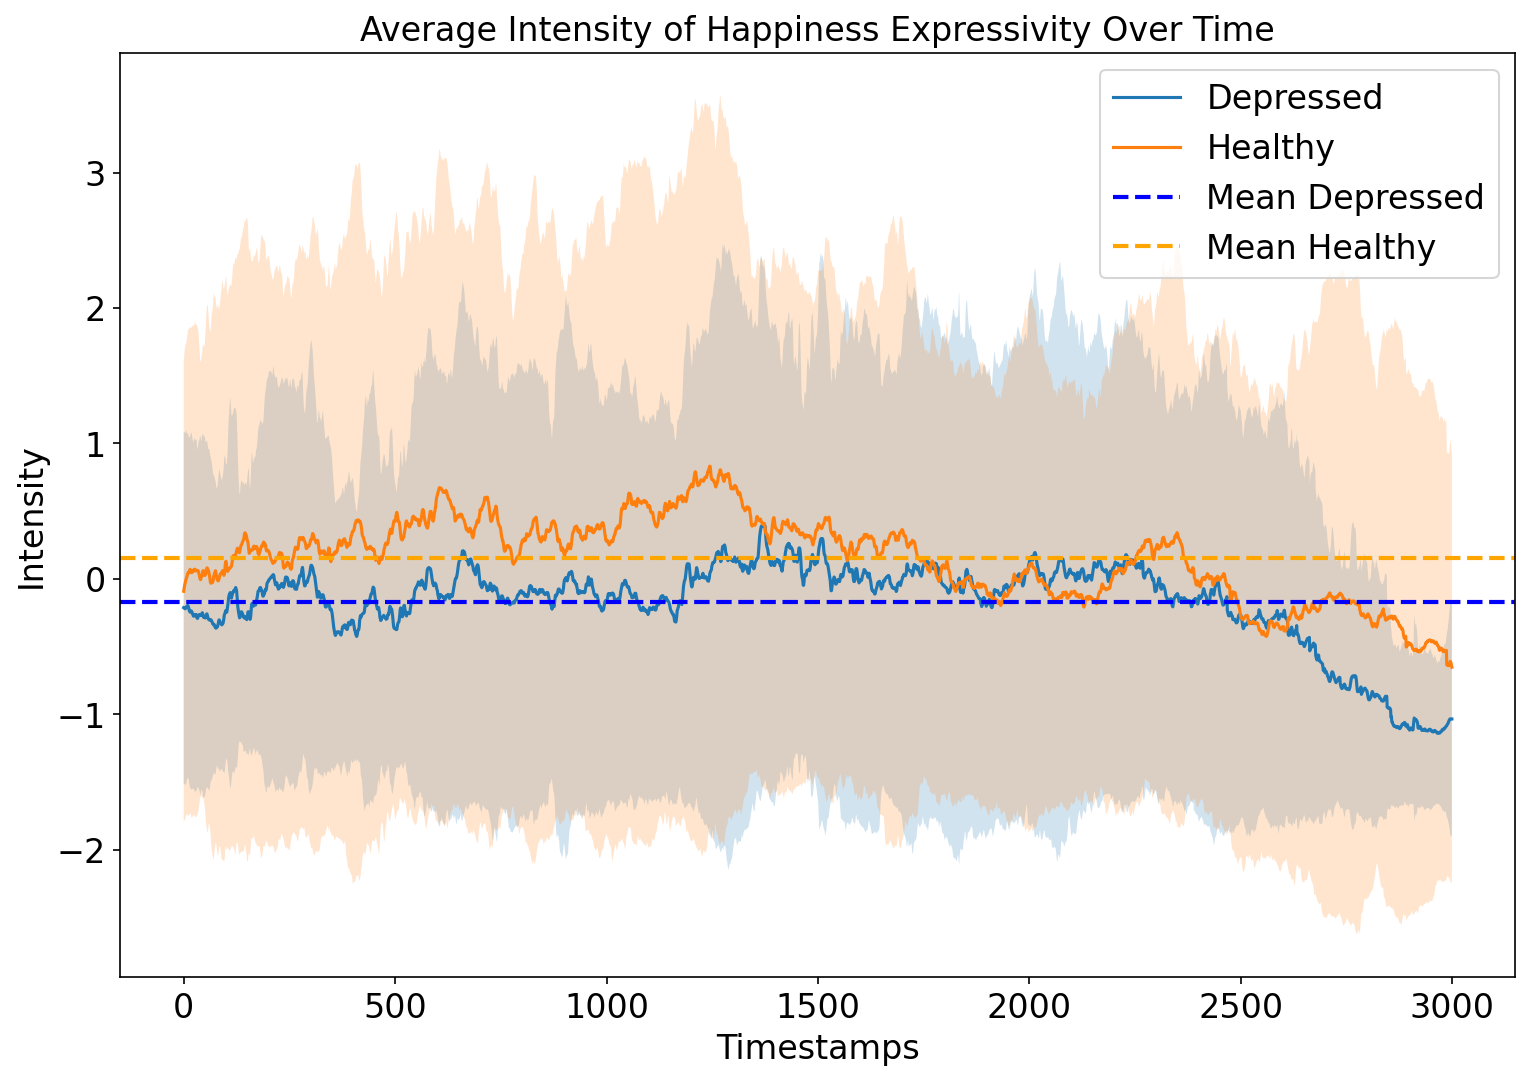

In [10]:
overall_mean_depressed = np.mean(mean_depressed)
overall_mean_non_depressed = np.mean(mean_non_depressed)

plt.figure(figsize=(12, 8), dpi=150)
plt.plot(mean_depressed, label='Depressed')
plt.plot(mean_non_depressed, label='Healthy')

# Fill between for standard deviation
plt.fill_between(np.arange(3000), mean_depressed - std_depressed, mean_depressed + std_depressed, alpha=0.2)
plt.fill_between(np.arange(3000), mean_non_depressed - std_non_depressed, mean_non_depressed + std_non_depressed, alpha=0.2)

# Add horizontal lines for overall mean values
plt.axhline(overall_mean_depressed, color='blue', linestyle='--', linewidth=2, label='Mean Depressed')
plt.axhline(overall_mean_non_depressed, color='orange', linestyle='--', linewidth=2, label='Mean Healthy')

# Add labels and title
plt.legend(fontsize=16)
plt.title('Average Intensity of Happiness Expressivity Over Time', fontsize=16)
plt.xlabel('Timestamps', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# Show the plot
plt.show()

In [57]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# # Extracting features: mean and standard deviation in windows of 100 timestamps
# window_size = 1
# features_depressed = []
# features_non_depressed = []

# for i in range(0, 3000, window_size):
#     window_depressed = depressed[:, i:i + window_size]
#     window_non_depressed = non_depressed[:, i:i + window_size]
    
#     mean_depressed = np.mean(window_depressed, axis=1)
#     std_depressed = np.std(window_depressed, axis=1)
#     mean_non_depressed = np.mean(window_non_depressed, axis=1)
#     std_non_depressed = np.std(window_non_depressed, axis=1)
    
#     features_depressed.append(np.vstack((mean_depressed, std_depressed)).T)
#     features_non_depressed.append(np.vstack((mean_non_depressed, std_non_depressed)).T)

# features_depressed = np.hstack(features_depressed)
# features_non_depressed = np.hstack(features_non_depressed)

# # Combine features and normalize
# X = np.vstack((features_depressed, features_non_depressed))
# y_combined = np.hstack((np.ones(depressed.shape[0]), np.zeros(non_depressed.shape[0])))

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [58]:
reshaped_array_flat.shape

(100, 3000)

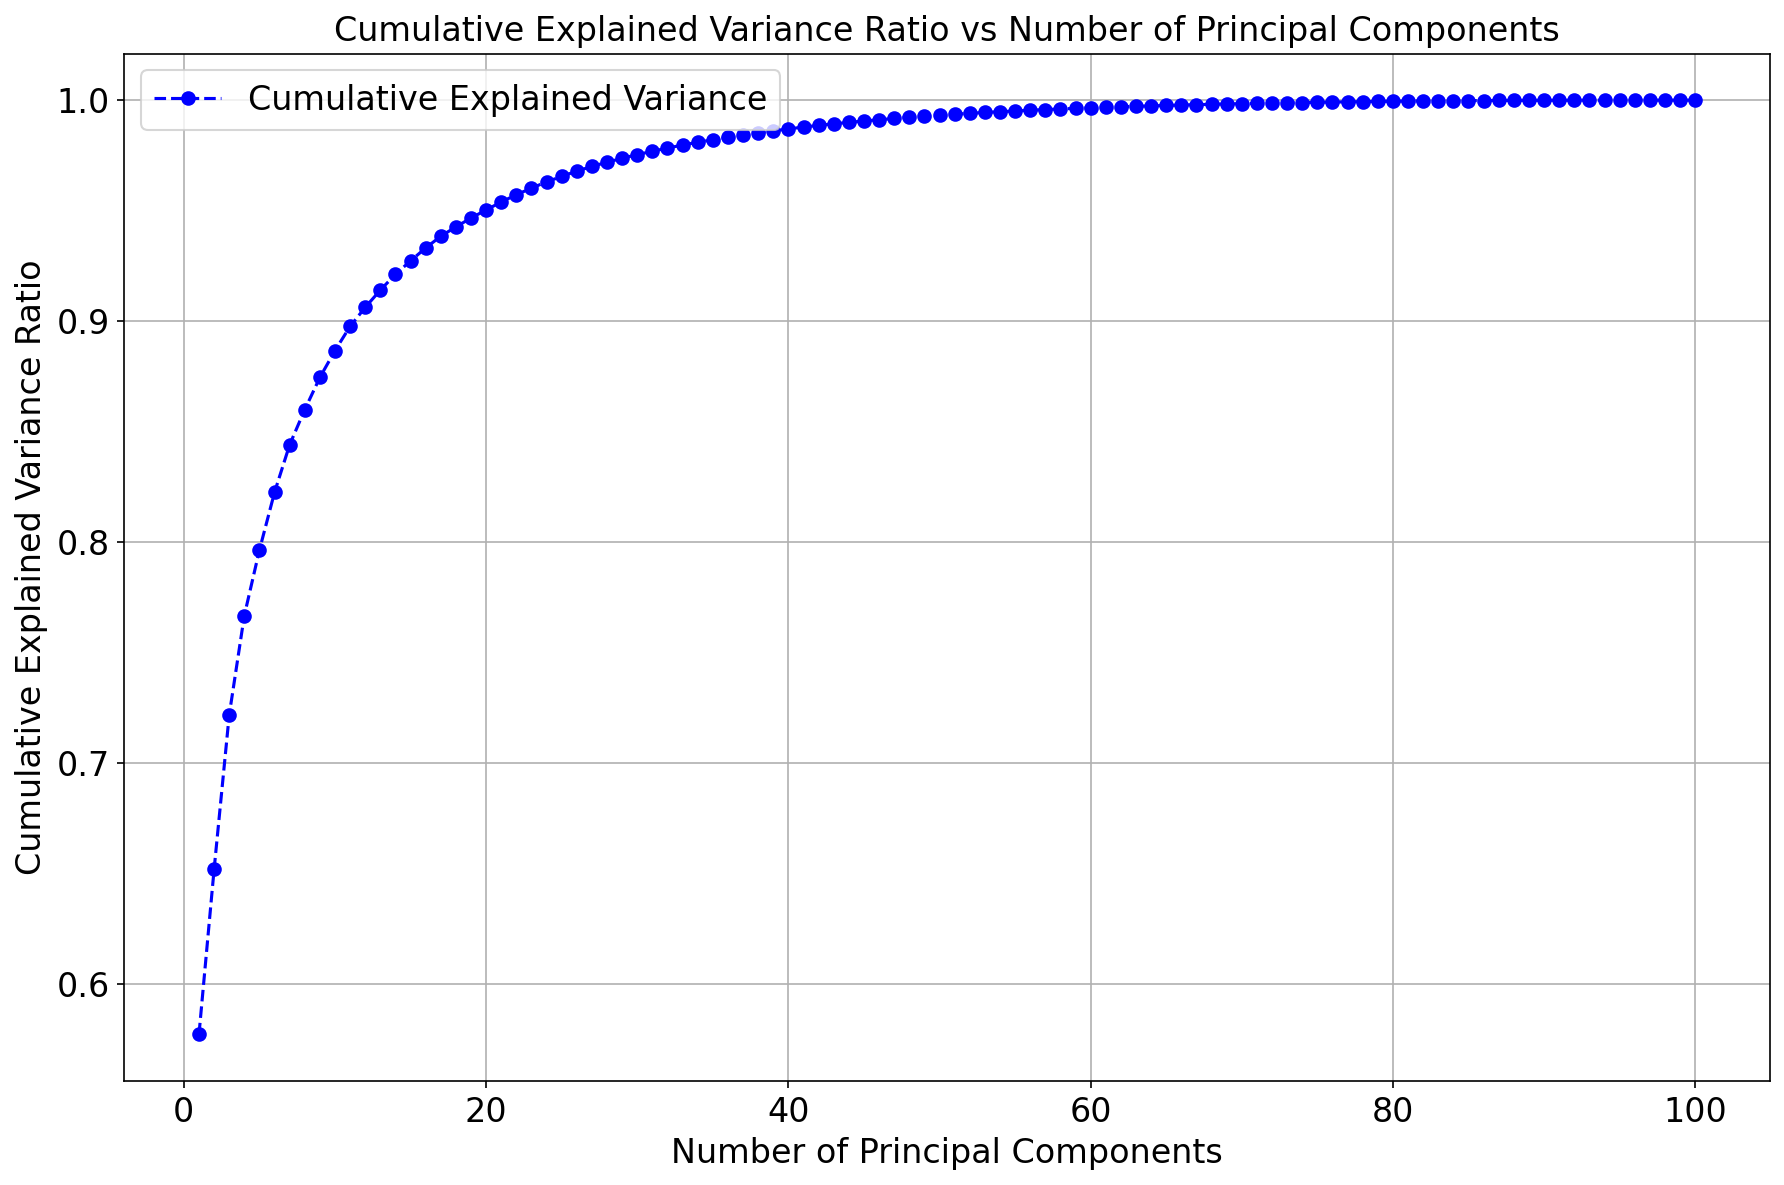

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA()

# Fit PCA
pca.fit(reshaped_array_flat)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
# plt.figure(figsize=(12, 8))
# plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 
#         align='center', label='Explained Variance Ratio')
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.title('Explained Variance Ratio per Principal Component')
# plt.legend()
# plt.tight_layout()
# plt.show()

# Plot cumulative explained variance
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, 
         marker='o', linestyle='--', color='b', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components', fontsize=16)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=16)
plt.title('Cumulative Explained Variance Ratio vs Number of Principal Components', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

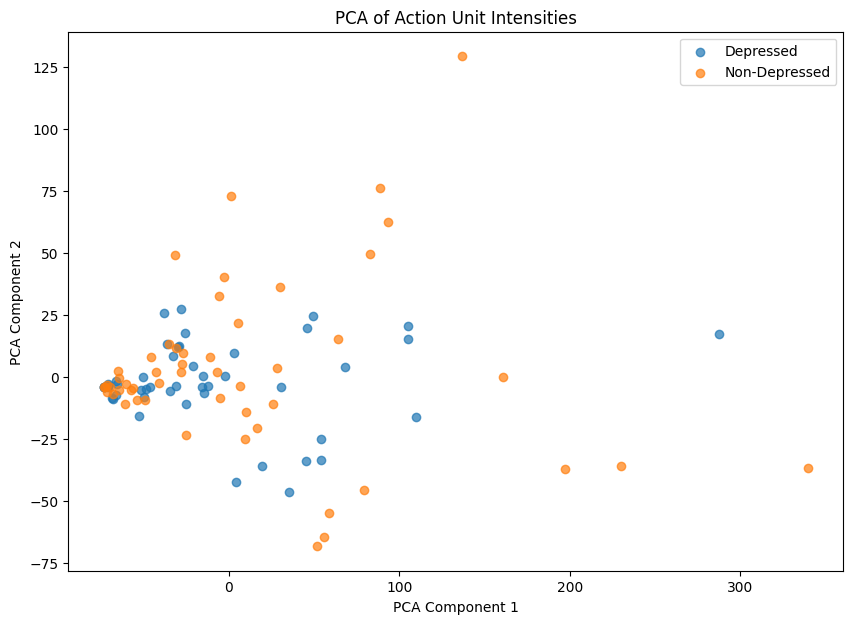

In [74]:
# Reduce dimensions for clustering
pca = PCA(n_components=15)
X_pca = pca.fit_transform(reshaped_array_flat)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[y == 1][:, 0], X_pca[y == 1][:, 1], label='Depressed', alpha=0.7)
plt.scatter(X_pca[y == 0][:, 0], X_pca[y == 0][:, 1], label='Non-Depressed', alpha=0.7)
plt.title('PCA of Action Unit Intensities')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [79]:
# from mpl_toolkits.mplot3d import Axes3D

# # Select the first three principal components
# X_pca_3d = X_pca[:, :3]

# # K-Means clustering
# kmeans = KMeans(n_clusters=2, random_state=42)
# clusters = kmeans.fit_predict(X_pca_3d)

# # Plotting in 3D
# fig = plt.figure(figsize=(12, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_pca_3d[clusters == 0][:, 0], X_pca_3d[clusters == 0][:, 1], X_pca_3d[clusters == 0][:, 2], c='b', label='Cluster 1', alpha=0.7)
# ax.scatter(X_pca_3d[clusters == 1][:, 0], X_pca_3d[clusters == 1][:, 1], X_pca_3d[clusters == 1][:, 2], c='r', label='Cluster 2', alpha=0.7)
# ax.set_title('K-Means Clustering of Action Unit Intensities (PCA Components 1, 2, and 3)')
# ax.set_xlabel('PCA Component 1')
# ax.set_ylabel('PCA Component 2')
# ax.set_zlabel('PCA Component 3')
# ax.legend()
# plt.show()

/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.47825839860116853


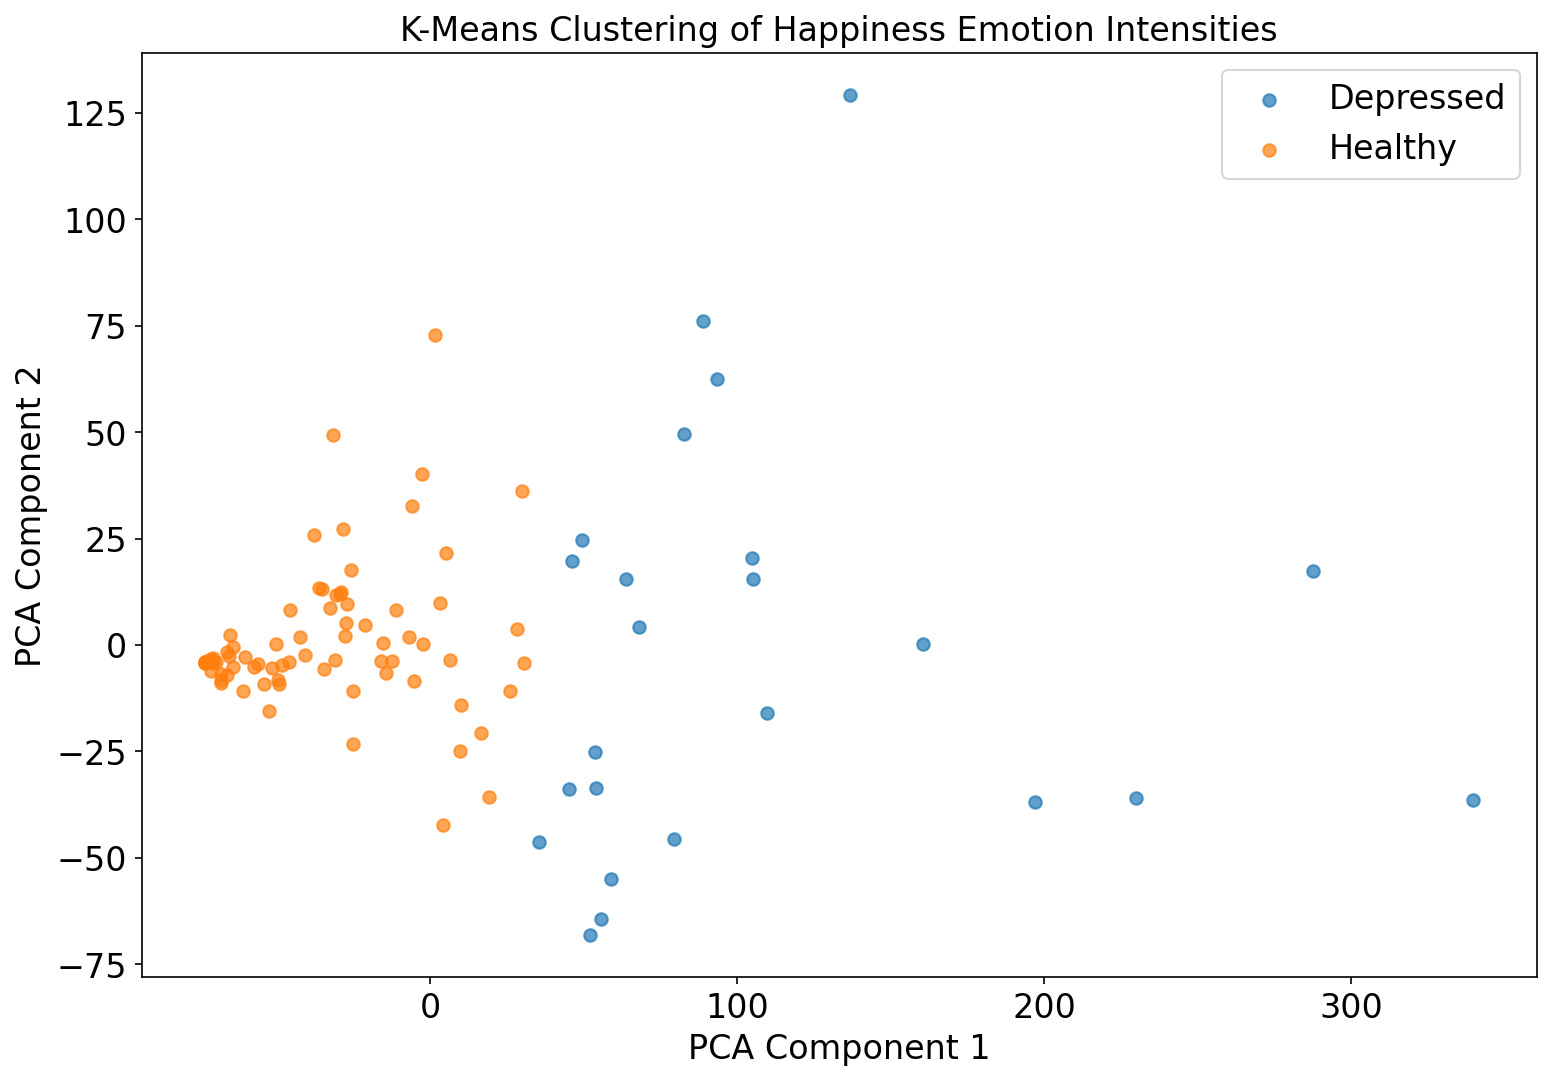

In [86]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Silhouette score to evaluate clustering
sil_score = silhouette_score(X_pca, clusters)
print(f'Silhouette Score: {sil_score}')

plt.figure(figsize=(12, 8), dpi=150)
plt.scatter(X_pca[clusters == 0][:, 0], X_pca[clusters == 0][:, 1], label='Depressed', alpha=0.7)
plt.scatter(X_pca[clusters == 1][:, 0], X_pca[clusters == 1][:, 1], label='Healthy', alpha=0.7)
plt.title('K-Means Clustering of Happiness Emotion Intensities', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=16)
plt.ylabel('PCA Component 2', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

A Silhouette Score of 0.6034 indicates a fairly good clustering structure. This means that the clusters are well-defined, with a reasonable separation between clusters and cohesion within clusters.

Agglomerative Clustering Silhouette Score: 0.4399425510854717


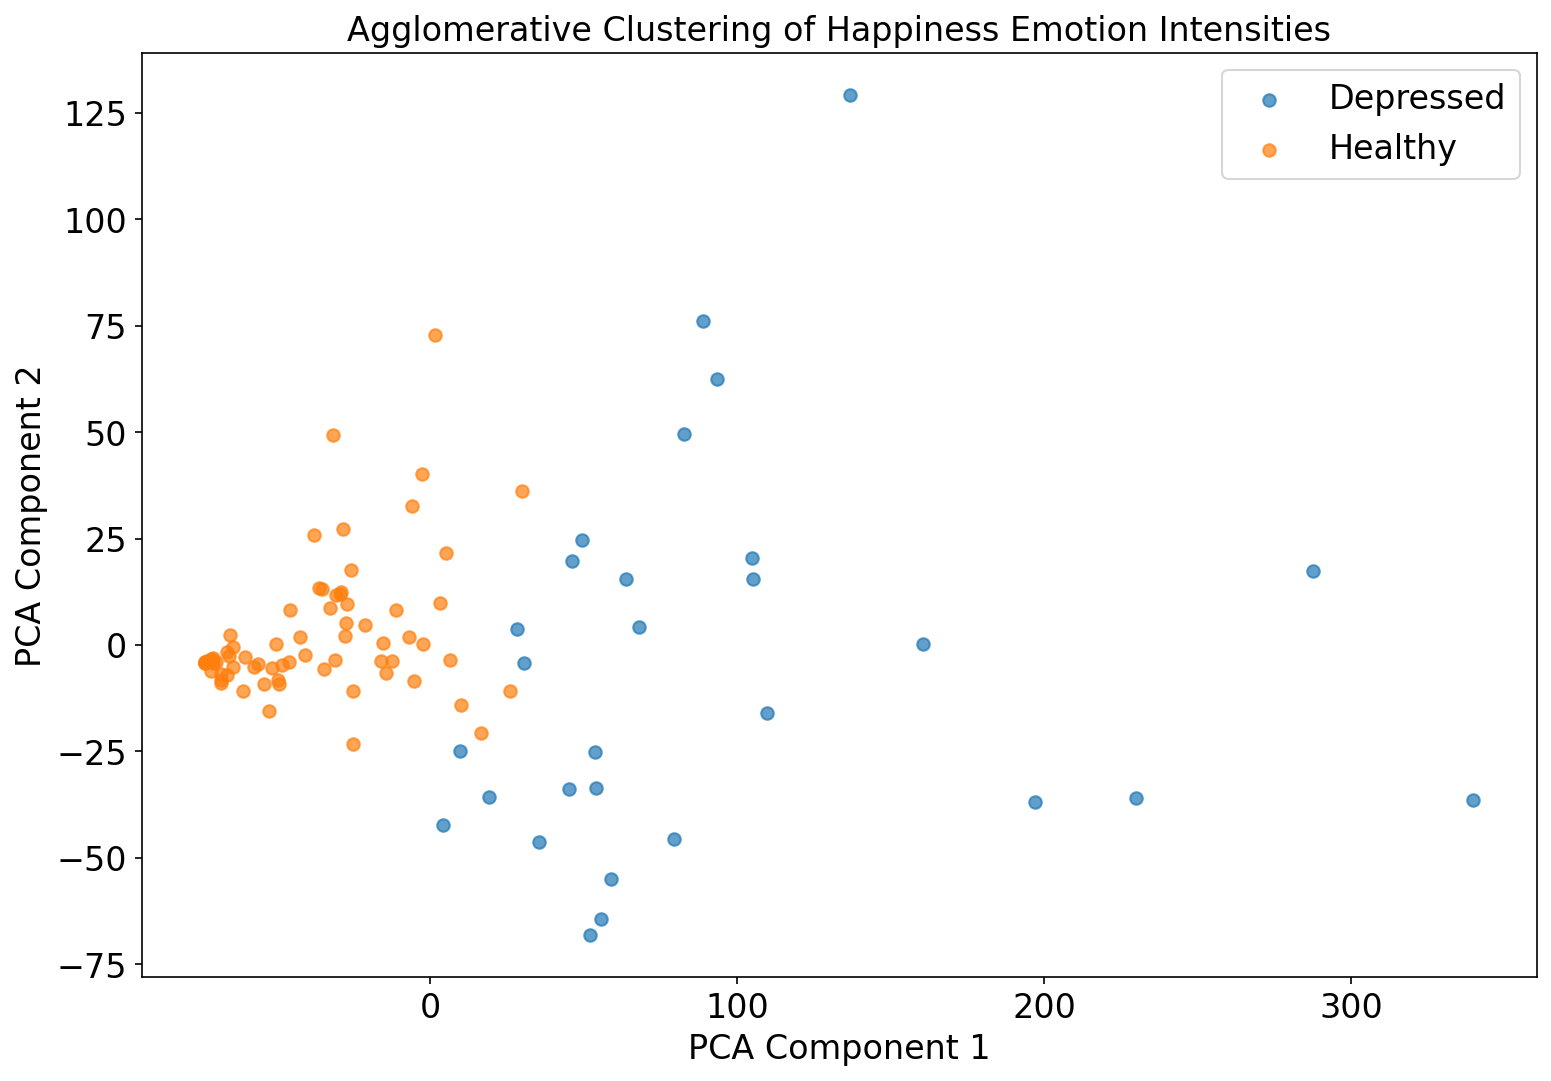

In [88]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=2)
clusters_agglo = agglo.fit_predict(X_pca)

# Silhouette score for Agglomerative Clustering
sil_score_agglo = silhouette_score(X_pca, clusters_agglo)
print(f'Agglomerative Clustering Silhouette Score: {sil_score_agglo}')

plt.figure(figsize=(12, 8), dpi=150)
plt.scatter(X_pca[clusters_agglo == 0][:, 0], X_pca[clusters_agglo == 0][:, 1], label='Depressed', alpha=0.7)
plt.scatter(X_pca[clusters_agglo == 1][:, 0], X_pca[clusters_agglo == 1][:, 1], label='Healthy', alpha=0.7)
plt.title('Agglomerative Clustering of Happiness Emotion Intensities', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=16)
plt.ylabel('PCA Component 2', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

GMM Silhouette Score: 0.4378469220738049


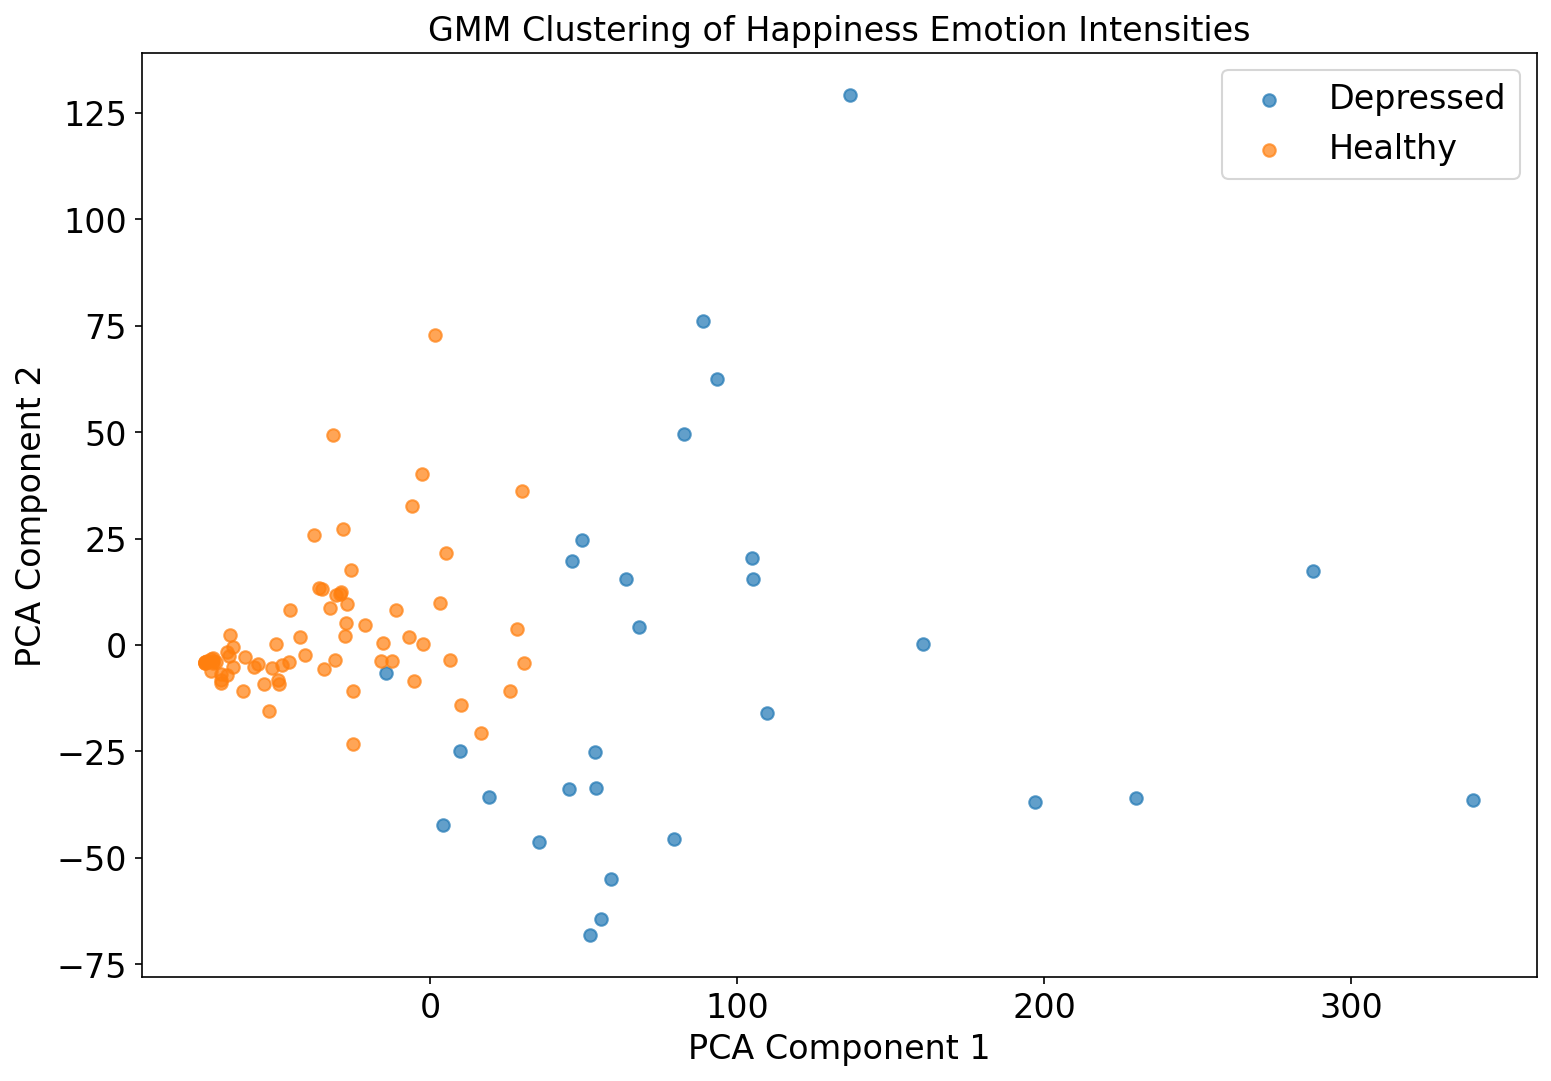

In [90]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
clusters_gmm = gmm.fit_predict(X_pca)

# Silhouette score for GMM
sil_score_gmm = silhouette_score(X_pca, clusters_gmm)
print(f'GMM Silhouette Score: {sil_score_gmm}')

# Plotting the clusters
plt.figure(figsize=(12, 8), dpi=150)
plt.scatter(X_pca[clusters_gmm == 0][:, 0], X_pca[clusters_gmm == 0][:, 1], label='Depressed', alpha=0.7)
plt.scatter(X_pca[clusters_gmm == 1][:, 0], X_pca[clusters_gmm == 1][:, 1], label='Healthy', alpha=0.7)
plt.title('GMM Clustering of Happiness Emotion Intensities', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=16)
plt.ylabel('PCA Component 2', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [48]:
X = summed_array.reshape(100, 3000)

In [49]:
from scipy.stats import ttest_ind

# Separate sadness intensity for both groups
sadness_depressed = X[y == 1]
sadness_non_depressed = X[y == 0]

# Compute the mean sadness intensity for each patient
mean_sadness_depressed = np.mean(sadness_depressed, axis=1)
mean_sadness_non_depressed = np.mean(sadness_non_depressed, axis=1)

# Perform t-test
t_stat, p_value = ttest_ind(mean_sadness_depressed, mean_sadness_non_depressed)
print(f'T-Test: t-statistic = {t_stat}, p-value = {p_value}')

T-Test: t-statistic = -1.1530859520556087, p-value = 0.251679819895193


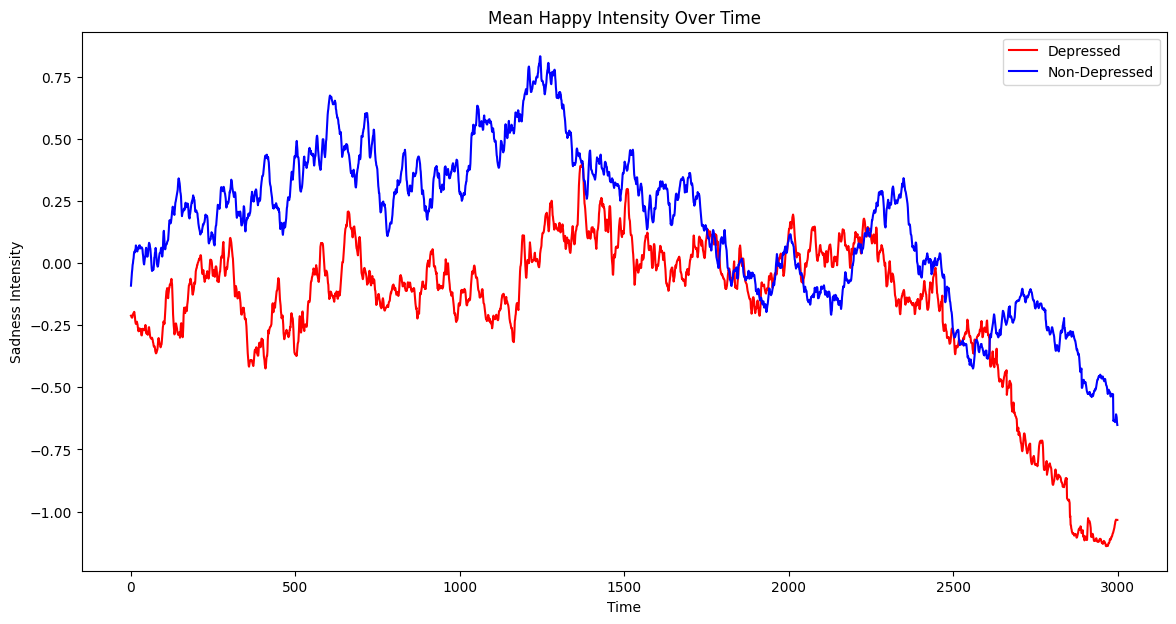

In [52]:
import matplotlib.pyplot as plt

# Compute the mean sadness intensity over time for both groups
mean_time_series_depressed = np.mean(sadness_depressed, axis=0)
mean_time_series_non_depressed = np.mean(sadness_non_depressed, axis=0)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(mean_time_series_depressed, label='Depressed', color='r')
plt.plot(mean_time_series_non_depressed, label='Non-Depressed', color='b')
plt.title('Mean Happy Intensity Over Time')
plt.xlabel('Time')
plt.ylabel('Sadness Intensity')
plt.legend()
plt.show()

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_proba)}')

# Feature Importance (in this context, it may be less relevant as we only have one feature per timestamp

              precision    recall  f1-score   support

           0       0.69      0.45      0.55        20
           1       0.35      0.60      0.44        10

    accuracy                           0.50        30
   macro avg       0.52      0.53      0.49        30
weighted avg       0.58      0.50      0.51        30

ROC-AUC Score: 0.5075000000000001
